In [ ]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [ ]:
class Particle:
    def __init__(self, dim):
        g1=random.randint(1, 99)
        g2=random.choice((0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625))
        g3=random.uniform(10, 200)
        g4=random.uniform(10, 200)
        self.position = np.array([g1,g2,g3,g4])
        self.velocity = np.random.rand(dim)
        self.best_position = self.position
        self.best_score = float('inf')

    def update_best(self, new_position, new_score):
        if new_score < self.best_score:
            self.best_position = new_position
            self.best_score = new_score

In [ ]:
def pressure_vessel_fitness(individual):
    # Fitness function for Pressure Vessel Design problem
    x=individual.copy()
    x[0] *= 0.0625   # Convert d1 to "in"

    y = 0.6224*x[0]*x[2]*x[3] + 1.7781*x[1]*x[2]**2 + 3.1661*x[0]**2*x[3] + 19.84*x[0]**2*x[2]

    g1 = -x[0] + 0.0193*x[2]
    g2 = -x[1] + 0.00954*x[2]
    g3 = -math.pi*x[2]**2*x[3] - (4/3)*math.pi*x[2]**3 + 1296000
    g4 = x[3] - 240
    g = [g1, g2, g3, g4]

    phi = sum(max(item, 0) for item in g)
    eps = 1e-5  # Tolerance to escape the constraint region
    penalty = 1e7  # Large penalty to add if constraints are violated

    if phi > eps:
        fitness = phi + penalty
    else:
        fitness = y
    return fitness

In [ ]:
class Hyperparameter_tuning:
    def __init__(self,w,c1,c2,c1f=0.5,c2f=2):
        #inisializaion
        self.w=w
        self.c1=c1
        self.c2=c2
        # second method
        self.w_max=0.9
        self.w_min=0.001
        # third method
        self.c1f=c1f
        self.c2f=c2f
    def fixed(self):
        return self.w,self.c1,self.c2
    def Oscillating_Inertia_Weight(self,s,t,k=1):
        # s = all generation
        # t = number of this time generation
        # k = Movement coefficient
        s1= (3*s)/4
        T = (2*s1)/(3*2*(k+1))
        cosine= 2 * np.pi * t / T
        self.w=((self.w_max+self.w_min)/2)+((self.w_max-self.w_min)/2)*np.cos(cosine)
    def Time_varying_acceleration_coefficients(self,s,t):
        self.c1=((self.c1-self.c1f)*((s-t)/s))+self.c1f
        self.c2=((self.c2-self.c2f)*((s-t)/s))+self.c2f
    def Sine_cosine_acceleration_coefficients(self,s,t):
        Partial_Derivative=2
        Variation=0.5
        self.c1= Partial_Derivative * np.sin((1-(t/s))*(np.pi/2))+Variation
        self.c2= Partial_Derivative * np.cos((1-(t/s))*(np.pi/2))+Variation
    def Adaptive(self,f_max,f_min,f_avg):
        omega = 1  # Constant parameter (can be adjusted if needed)
        phi = 1  # Constant parameter (can be adjusted if needed)
        X = 1  # Constant parameter (can be adjusted if needed)

    # Ensure f_avg is not zero to avoid division by zero
        if f_avg == 0:
            raise ValueError("f_avg cannot be zero")

    # Vectorized calculations using NumPy arrays
        delta = np.power((f_max - f_min) / f_avg, omega)
        landa = X * (1 + phi * np.power(f_max - f_min, omega) - np.power(f_avg, omega)) / (
        delta * np.power(f_max - f_min, omega) - np.power(f_avg, omega)
    )

    # Update c1 and c2 in-place using vectorized multiplication
        landa = round(landa, 2)

        c1=self.c1* (1 - landa)
        c2=self.c1* (2 - landa)
        return round(c1,2), round(c2,2)

    def Nonlinear_dynamic_acceleration_coefficients(self,s,t):
        self.c1,self.c1f=self.c1f,self.c1
        self.c2,self.c2f=self.c2f,self.c2
        c1= ((-1* (self.c1f - self.c1))*((t/s)**2))+self.c1f
        c2 = (self.c2 * ((1-(t/s))**2))+(self.c2f * (t/s))
        return  self.w,c1,c2








In [ ]:
class PSO:
    def __init__(self, fitness_function, dim, num_particles, max_iter, w=0.9, c1=2.5, c2=0.1):
        self.fitness_function = fitness_function
        self.dim = dim
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive weight
        self.c2 = c2  # Social weight
        self.particles = [Particle(dim) for _ in range(num_particles)]
        self.min=[1,0.0625,10,10]
        self.max=[99,0.625,200,200]
        self.global_best_position = [0,0,0,0]
        self.global_best_score = float('inf')
        self.Hyperparameter_tuni=Hyperparameter_tuning(w,c1,c2)
        self.tuning_method = getattr(self.Hyperparameter_tuni,"fixed")
    def optimize(self):

        for i in range(self.max_iter):

            for particle in self.particles:

                score = self.fitness_function(particle.position)
                particle.update_best(particle.position, score)

                if score < 0:
                    print("found")
                    continue

                if score < self.global_best_score:
                    self.global_best_position = particle.position
                    self.global_best_score = score

            for particle in self.particles:
                # Update velocity

                new_velocity = (self.w * particle.velocity +
                self.c1 * np.random.rand(self.dim) * (particle.best_position - particle.position) +
                self.c2 * np.random.rand(self.dim) * (self.global_best_position - particle.position))

                particle.velocity = np.round(new_velocity,4)

                # Update position
                new_position = particle.position + new_velocity
                new_position=np.clip(new_position,self.min,self.max)
                particle.position = new_position

            update parameters
            a=self.particles.copy()
            a=sorted(a, key=lambda particle: particle.best_score)
            sum_score=0
            self.Hyperparameter_tuni.Oscillating_Inertia_Weight(self.max_iter,i)
            for i in a : sum_score=sum_score+i.best_score;
            f_max=round(a[0].best_score,2)
            f_min=a[-1].best_score
            f_avg=(sum_score/len(a))
            self.c1,self.c2=self.Hyperparameter_tuni.Adaptive(f_max=f_max,f_min=f_min,f_avg=f_avg)
            self.w= self.tuning_method()[0]

            self.Hyperparameter_tuni.Oscillating_Inertia_Weight(self.max_iter,i)
            self.w,self.c1,self.c2=self.Hyperparameter_tuni.Nonlinear_dynamic_acceleration_coefficients(self.max_iter,i)


        return self.global_best_score





# Plot Oscillating Inertia Weight

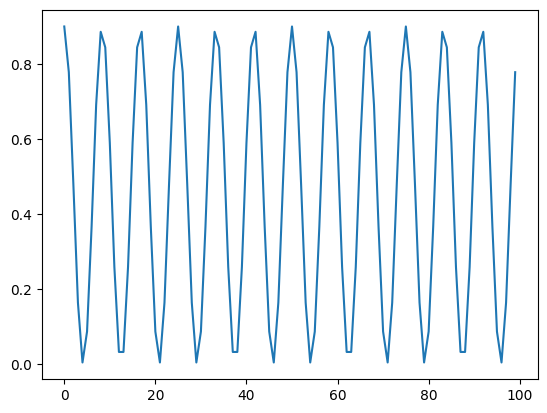

In [ ]:
a=Hyperparameter_tuning(w=0.9, c1=2.5, c2=0.1)
main=[]
for i in range(100):
    a.Oscillating_Inertia_Weight(100,i,k=2)
    main.append(a.fixed()[0])
plt.plot(main)

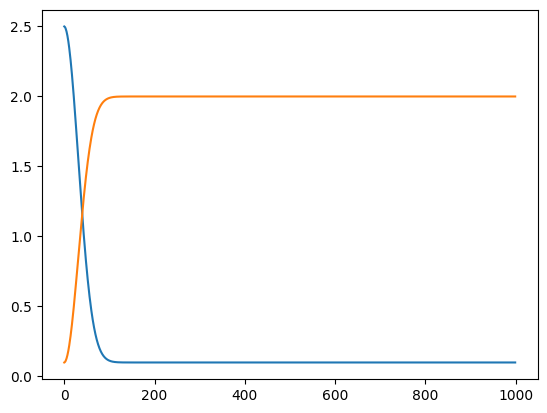

In [ ]:
c1=[]
c2=[]
for i in range(1000):
    a.Time_varying_acceleration_coefficients(1000,i)
    c1.append(a.fixed()[1])
    c2.append(a.fixed()[2])
plt.plot(c1,label="c1")
plt.plot(c2,label="c2")

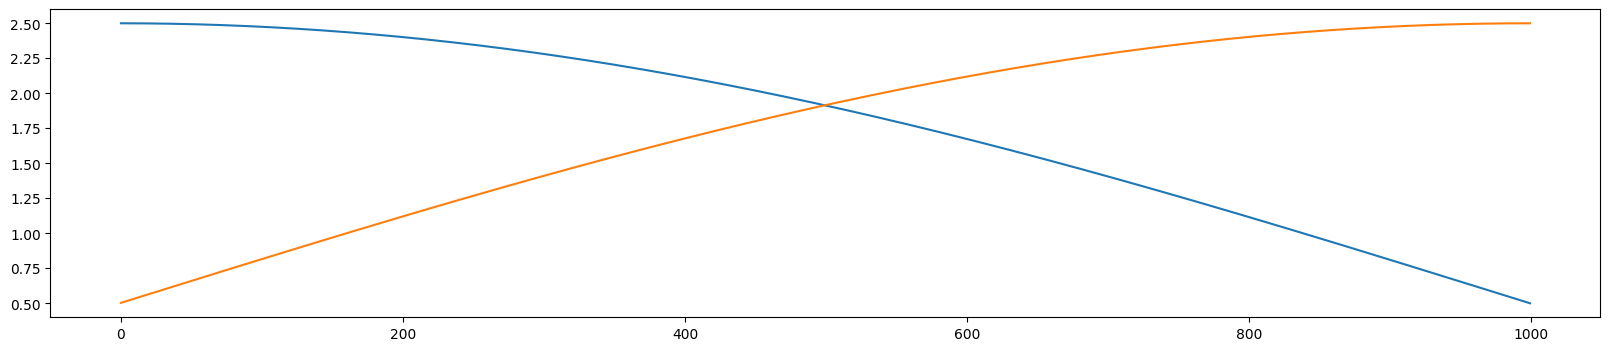

In [ ]:
c1=[]
c2=[]
for i in range(1,1001):
    a.Sine_cosine_acceleration_coefficients(1000,i)
    c1.append(a.fixed()[1])
    c2.append(a.fixed()[2])
plt.figure(figsize=(20, 4))
plt.plot(c1,label="c1")
plt.plot(c2,label="c2")


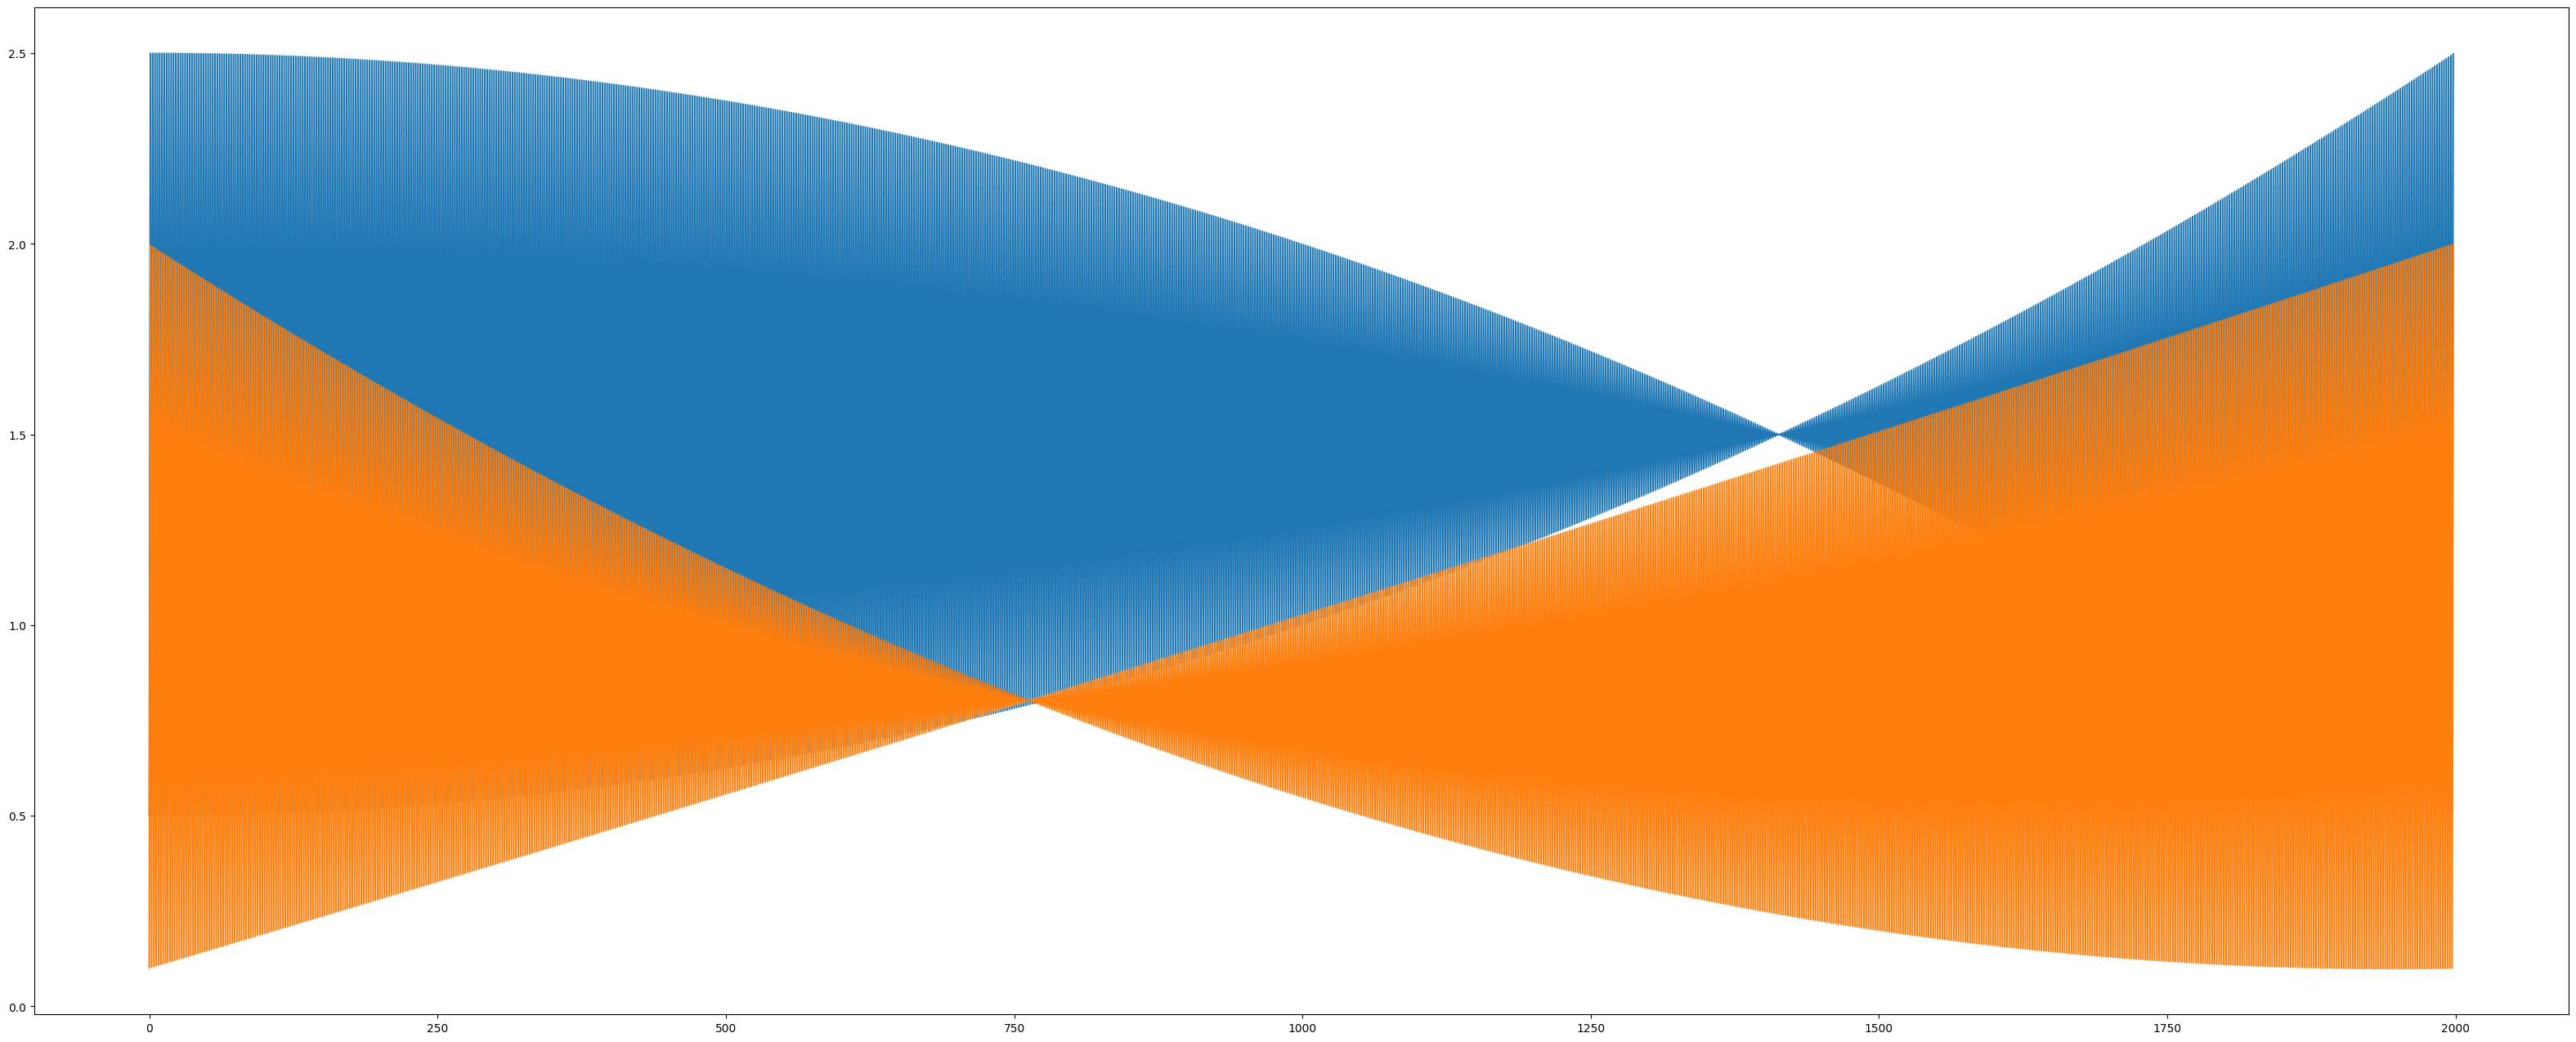

In [ ]:
c1=[]
c2=[]
for i in range(1,2000):
    o,n,m=a.Nonlinear_dynamic_acceleration_coefficients(2000,i)
    c1.append(n)
    c2.append(m)
plt.figure(figsize=(40, 16))
plt.plot(c1,label="c1")
plt.plot(c2,label="c2")

<h1>testing</h1>

W change


\begin{equation}

w(t) = \frac{w_\text{max} + w_\text{min}}{2} + \frac{w_\text{max} - w_\text{min}}{2} \cos \left( \frac{2\pi t}{T} \right)
\end{equation}
\begin{equation}
T = \frac{2S}{3 + 2k}
\end{equation}


In [ ]:
dim = 4 # Dimension of the problem
num_particles = 100
max_iter = 5000
score=[]
for i in range(10):
    pso = PSO(pressure_vessel_fitness, dim, num_particles, max_iter=max_iter)
    score.append(pso.optimize())
    print(score)

[6710.465085313563]
[6710.465085313563, 6267.780357535419]
[6710.465085313563, 6267.780357535419, 5912.64467899708]
[6710.465085313563, 6267.780357535419, 5912.64467899708, 6580.600923891241]
[6710.465085313563, 6267.780357535419, 5912.64467899708, 6580.600923891241, 5890.628204441654]
[6710.465085313563, 6267.780357535419, 5912.64467899708, 6580.600923891241, 5890.628204441654, 6685.26589015092]
[6710.465085313563, 6267.780357535419, 5912.64467899708, 6580.600923891241, 5890.628204441654, 6685.26589015092, 6737.872607508604]
[6710.465085313563, 6267.780357535419, 5912.64467899708, 6580.600923891241, 5890.628204441654, 6685.26589015092, 6737.872607508604, 6686.420589156128]
[6710.465085313563, 6267.780357535419, 5912.64467899708, 6580.600923891241, 5890.628204441654, 6685.26589015092, 6737.872607508604, 6686.420589156128, 6616.802391299477]
[6710.465085313563, 6267.780357535419, 5912.64467899708, 6580.600923891241, 5890.628204441654, 6685.26589015092, 6737.872607508604, 6686.4205891561

<h1>Time-varying acceleration coefficients</h1>
\begin{equation}
c_1 = (c_{1u} - c_{1f})\frac{iter_{max} - iter}{iter_{max}} + c_{1f}
\end{equation}
\begin{equation}
c_2 = (c_{2u} - c_{2f})\frac{iter_{max} - iter}{iter_{max}} + c_{2f}
\end{equation}

In [ ]:
dim = 4 # Dimension of the problem
num_particles = 100
max_iter = 5000
score=[]
for i in range(10):
    pso = PSO(pressure_vessel_fitness, dim, num_particles, max_iter=max_iter)
    score.append(pso.optimize())
    print(score)

[5972.49435723609]
[5972.49435723609, 7025.58372278008]
[5972.49435723609, 7025.58372278008, 6968.267126182558]
[5972.49435723609, 7025.58372278008, 6968.267126182558, 6213.738925228565]
[5972.49435723609, 7025.58372278008, 6968.267126182558, 6213.738925228565, 7072.081673780089]
[5972.49435723609, 7025.58372278008, 6968.267126182558, 6213.738925228565, 7072.081673780089, 6824.005911605866]
[5972.49435723609, 7025.58372278008, 6968.267126182558, 6213.738925228565, 7072.081673780089, 6824.005911605866, 6807.041335832757]
[5972.49435723609, 7025.58372278008, 6968.267126182558, 6213.738925228565, 7072.081673780089, 6824.005911605866, 6807.041335832757, 6932.206270481882]
[5972.49435723609, 7025.58372278008, 6968.267126182558, 6213.738925228565, 7072.081673780089, 6824.005911605866, 6807.041335832757, 6932.206270481882, 7234.478076411455]
[5972.49435723609, 7025.58372278008, 6968.267126182558, 6213.738925228565, 7072.081673780089, 6824.005911605866, 6807.041335832757, 6932.206270481882, 72

<h1>Sine cosine acceleration coefficients</h1>
\begin{equation}
c_1 = \theta \times \sin\left(\left(1 - \frac{iter}{iter_\text{max}}\right) \times \frac{\pi}{2}\right) + \delta
\end{equation}
\begin{equation}
c_2 = \theta \times \cos\left(\left(1 - \frac{iter}{iter_\text{max}}\right) \times \frac{\pi}{2}\right) + \delta
\end{equation}
\begin{equation}
\theta = 2, \delta = 0.5
\end{equation}


In [ ]:
dim = 4 # Dimension of the problem
num_particles = 100
max_iter = 5000
score=[]
for i in range(10):
    pso = PSO(pressure_vessel_fitness, dim, num_particles, max_iter=max_iter)
    score.append(pso.optimize())
    print(score)

[6051.433748147237]
[6051.433748147237, 5903.688595122256]
[6051.433748147237, 5903.688595122256, 6039.488698019375]
[6051.433748147237, 5903.688595122256, 6039.488698019375, 5944.000829343693]
[6051.433748147237, 5903.688595122256, 6039.488698019375, 5944.000829343693, 6316.641048011609]
[6051.433748147237, 5903.688595122256, 6039.488698019375, 5944.000829343693, 6316.641048011609, 6580.020036296807]
[6051.433748147237, 5903.688595122256, 6039.488698019375, 5944.000829343693, 6316.641048011609, 6580.020036296807, 6580.020036296807]
[6051.433748147237, 5903.688595122256, 6039.488698019375, 5944.000829343693, 6316.641048011609, 6580.020036296807, 6580.020036296807, 6580.020036296807]
[6051.433748147237, 5903.688595122256, 6039.488698019375, 5944.000829343693, 6316.641048011609, 6580.020036296807, 6580.020036296807, 6580.020036296807, 5918.597694550268]
[6051.433748147237, 5903.688595122256, 6039.488698019375, 5944.000829343693, 6316.641048011609, 6580.020036296807, 6580.020036296807, 65

<h1>Adaptive</h1>
\begin{document}
\begin{flushleft}
nc_1 = c_1 \times (1 - \lambda) \qquad (3)
\\
nc_2 = c_2 \times (1 + \lambda) \qquad (4)
\\
\text{In Equ. (3) and (4), the $\lambda$ value is computed based on the fitness values is calculated as,}
\\
\lambda = \frac{f^{(\theta)} (1 + \phi (f_\text{max} - f_\text{min}))^{\theta} - (f_\text{avg}^{(\theta)})}{
\delta^{(\theta)} (f_\text{max} - f_\text{min})^{(\theta)} - f_\text{avg}^{(\theta)}} \qquad (5)
\\
\delta = \left(\frac{f_\text{max} - f_\text{min}}{f_\text{avg}}\right)^{\omega} \qquad (6)
\\
\text{Where,}\\
\lambda \text{ - Alteration probability}\\

\omega, \theta \text{ - Coefficient factors}\\
F_\text{max}, F_\text{min}, F_\text{avg} \text{ - Maximum, minimum and average fitness of the particles}
\end{flushleft}
\end{document}

In [ ]:
dim = 4 # Dimension of the problem
num_particles = 100
max_iter = 5000
score=[]
for i in range(10):
    pso = PSO(pressure_vessel_fitness, dim, num_particles, max_iter=max_iter)
    score.append(pso.optimize())
    print(score)

[6626.563849061592]
[6626.563849061592, 6934.916291955421]
[6626.563849061592, 6934.916291955421, 6872.663188365146]
[6626.563849061592, 6934.916291955421, 6872.663188365146, 6604.840477407269]
[6626.563849061592, 6934.916291955421, 6872.663188365146, 6604.840477407269, 6883.731460383542]
[6626.563849061592, 6934.916291955421, 6872.663188365146, 6604.840477407269, 6883.731460383542, 6731.653327003135]
[6626.563849061592, 6934.916291955421, 6872.663188365146, 6604.840477407269, 6883.731460383542, 6731.653327003135, 6713.60549011755]
[6626.563849061592, 6934.916291955421, 6872.663188365146, 6604.840477407269, 6883.731460383542, 6731.653327003135, 6713.60549011755, 6820.898304696188]
[6626.563849061592, 6934.916291955421, 6872.663188365146, 6604.840477407269, 6883.731460383542, 6731.653327003135, 6713.60549011755, 6820.898304696188, 6678.4809005735015]
[6626.563849061592, 6934.916291955421, 6872.663188365146, 6604.840477407269, 6883.731460383542, 6731.653327003135, 6713.60549011755, 6820.

<h1>Nonlinear dynamic acceleration coefficients</h1>

In [ ]:
dim = 4 # Dimension of the problem
num_particles = 100
max_iter = 5000
score=[]
for i in range(10):
    pso = PSO(pressure_vessel_fitness, dim, num_particles, max_iter=max_iter)
    score.append(pso.optimize())
    print(score)

[6580.15117213064]
[6580.15117213064, 5885.260279075756]
[6580.15117213064, 5885.260279075756, 6054.13737623493]
[6580.15117213064, 5885.260279075756, 6054.13737623493, 6580.020036296807]
[6580.15117213064, 5885.260279075756, 6054.13737623493, 6580.020036296807, 6580.0321212189965]
[6580.15117213064, 5885.260279075756, 6054.13737623493, 6580.020036296807, 6580.0321212189965, 6580.020036296807]
[6580.15117213064, 5885.260279075756, 6054.13737623493, 6580.020036296807, 6580.0321212189965, 6580.020036296807, 5885.260279075756]
[6580.15117213064, 5885.260279075756, 6054.13737623493, 6580.020036296807, 6580.0321212189965, 6580.020036296807, 5885.260279075756, 6587.4729984268315]
[6580.15117213064, 5885.260279075756, 6054.13737623493, 6580.020036296807, 6580.0321212189965, 6580.020036296807, 5885.260279075756, 6587.4729984268315, 5885.260279075756]
[6580.15117213064, 5885.260279075756, 6054.13737623493, 6580.020036296807, 6580.0321212189965, 6580.020036296807, 5885.260279075756, 6587.4729984

In [ ]:
w_change=[6710.465085313563, 6267.780357535419, 5912.64467899708, 6580.600923891241, 5890.628204441654, 6685.26589015092, 6737.872607508604, 6686.420589156128, 6616.802391299477, 6585.017166881253]
Time_varying_acceleration_coefficients=[5972.49435723609, 7025.58372278008, 6968.267126182558, 6213.738925228565, 7072.081673780089, 6824.005911605866, 6807.041335832757, 6932.206270481882, 7234.478076411455, 7112.743540577896]
Sine_cosine_acceleration_coefficients=[6051.433748147237, 5903.688595122256, 6039.488698019375, 5944.000829343693, 6316.641048011609, 6580.020036296807, 6580.020036296807, 6580.020036296807, 5918.597694550268, 6580.020036296807]
Adaptive=[6626.563849061592, 6934.916291955421, 6872.663188365146, 6604.840477407269, 6883.731460383542, 6731.653327003135, 6713.60549011755, 6820.898304696188, 6678.4809005735015, 6866.308024371329]
Nonlinear_dynamic_acceleration_coefficients=[6580.15117213064, 5885.260279075756, 6054.13737623493, 6580.020036296807, 6580.0321212189965, 6580.020036296807, 5885.260279075756, 6587.4729984268315, 5885.260279075756, 6580.020036296807]


In [ ]:
result_list=[w_change,Time_varying_acceleration_coefficients,Sine_cosine_acceleration_coefficients,Adaptive,Nonlinear_dynamic_acceleration_coefficients]

In [ ]:
final_resualt=[]
for i in result_list:
    temp=[]
    temp.append(i[0])
    temp.append(i[1])
    temp.append(((sum(temp))/len(temp)))
    final_resualt.append(temp)

In [ ]:
final_resualt

[[6710.465085313563, 6267.780357535419, 6489.122721424491],
 [5972.49435723609, 7025.58372278008, 6499.039040008085],
 [6051.433748147237, 5903.688595122256, 5977.561171634747],
 [6626.563849061592, 6934.916291955421, 6780.7400705085065],
 [6580.15117213064, 5885.260279075756, 6232.7057256031985]]

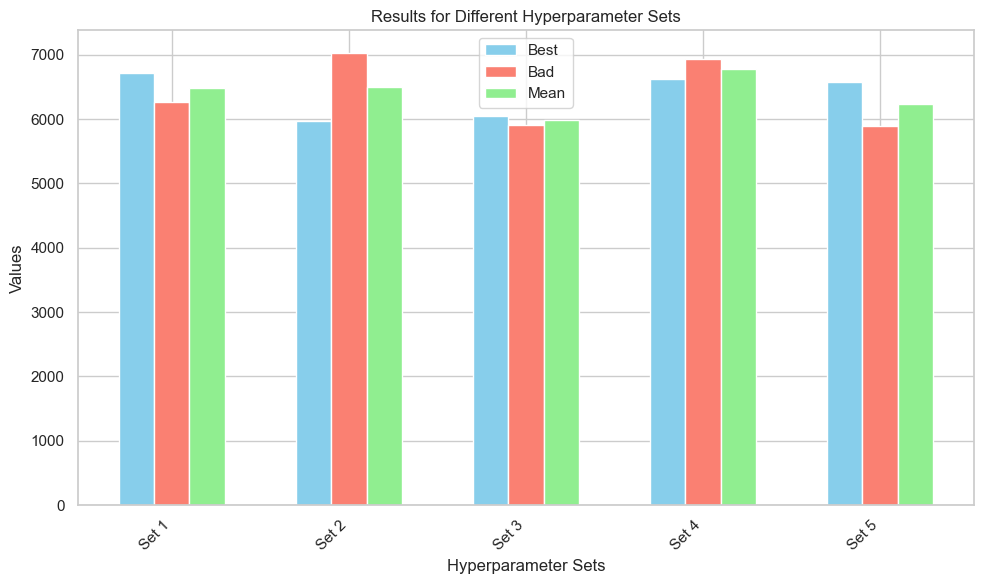

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = [
    [6710.465085313563, 6267.780357535419, 6489.122721424491],
    [5972.49435723609, 7025.58372278008, 6499.039040008085],
    [6051.433748147237, 5903.688595122256, 5977.561171634747],
    [6626.563849061592, 6934.916291955421, 6780.7400705085065],
    [6580.15117213064, 5885.260279075756, 6232.7057256031985]
]

# Extracting the values
best_values = [result[0] for result in results]
bad_values = [result[1] for result in results]
mean_values = [result[2] for result in results]

# Generating x-axis labels
labels = [f"Set {i+1}" for i in range(len(results))]

# Width of each bar
bar_width = 0.2
index = np.arange(len(results))

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plotting grouped bars
plt.bar(index - bar_width, best_values, bar_width, color='skyblue', label='Best')
plt.bar(index, bad_values, bar_width, color='salmon', label='Bad')
plt.bar(index + bar_width, mean_values, bar_width, color='lightgreen', label='Mean')

plt.xlabel('Hyperparameter Sets')
plt.ylabel('Values')
plt.title('Results for Different Hyperparameter Sets')
plt.xticks(index, labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
